In [13]:
import ast

import numpy as np
import pandas as pd
import torch

import src.preprocessing.sim_rir_dict as sim_rir_dict
from src.utils.unitary_linear_norm import unitary_norm

In [4]:
sim_rir_dict = sim_rir_dict.RoomCases().generate_room_cb()
train_rir_manifest = pd.read_csv("./data/noiseReverbSpeech/train_manifest_RIR.csv")

In [3]:
room_cases_values = [room_case for room_case in sim_rir_dict["rmID_4"].values()]
distRcvs = [room_case["distRcv"] for room_case in room_cases_values]
distRcvs = np.asarray(distRcvs)
# match the distance exactly
match_idx = np.where(np.isclose(distRcvs, 3.038))[0]
if len(match_idx) == 0:
    # randomly select the closest distance
    match_idx = np.argmin(np.abs(distRcvs - 3.038))
elif len(match_idx) > 1:
    # randomly select one of the matched distances
    match_idx = np.random.choice(match_idx[0], 1)


room_cases_values[int(match_idx)]

{'src': [1.775, 0.334, 1.928],
 'mic': (2.591, 3.179, 1.245),
 'volume': [2.801, 4.323, 2.677],
 'distRcv': 3.037}

In [5]:
def match_room_and_distance(dict_data, real_rir_manifest: pd.DataFrame, seed=42):
    """
    Match dict entries with dataframe rows for multiple roomIDs.

    Args:
        dict_data: Dictionary containing multiple roomIDs and their data
        df: DataFrame with roomID and distRcv columns
        seed: Random seed for reproducibility

    Returns:
        DataFrame with matched entries and additional tuples
    """
    manifest = []

    np.random.seed(seed)

    # Process each roomID in the dict
    for i in range(len(real_rir_manifest)):  # noqa: B007
        roomID = real_rir_manifest.iloc[i]["roomID"]
        distRcv = real_rir_manifest.iloc[i]["distRcv"]
        Tt = real_rir_manifest.iloc[i]["Tt"]
        volume_log10_norm = real_rir_manifest.iloc[i]["volume_log10_norm"]
        volume_ns = (
            np.asarray(ast.literal_eval(real_rir_manifest.iloc[i]["volume"]))
            .prod()
            .round(0)
        )
        distRcv_norm = real_rir_manifest.iloc[i]["distRcv_norm"]

        matched_room_cases = [case for case in dict_data[roomID].values()]

        distRcvs = [case["distRcv"] for case in matched_room_cases]

        distRcvs = np.asarray(distRcvs)

        matched_idx = np.where(np.isclose(distRcvs, distRcv))[0]
        match_type = "exact"

        if len(matched_idx) == 0:
            # randomly select the closest distance
            matched_idx = np.argmin(np.abs(distRcvs - distRcv))
        elif len(matched_idx) > 1:
            # randomly select one of the matched distances
            matched_idx = np.random.choice(matched_idx, 1)
            match_type = "random"

        matched_index = int(matched_idx.item())

        selected_case = matched_room_cases[matched_index]

        src_pos = list(selected_case["src"])
        mic_pos = list(selected_case["mic"])
        volume_dim = list(selected_case["volume"])

        # make sure src_pos and mic_pos are within the room, if not clip them to the room boundaries - 0.1
        src_pos[0] = np.clip(np.array(src_pos[0]), 0, volume_dim[0] - 0.1)
        src_pos[1] = np.clip(np.array(src_pos[1]), 0, volume_dim[1] - 0.1)
        src_pos[2] = np.clip(np.array(src_pos[2]), 0, volume_dim[2] - 0.1)
        mic_pos[0] = np.clip(np.array(mic_pos[0]), 0, volume_dim[0] - 0.1)
        mic_pos[1] = np.clip(np.array(mic_pos[1]), 0, volume_dim[1] - 0.1)
        mic_pos[2] = np.clip(np.array(mic_pos[2]), 0, volume_dim[2] - 0.1)

        # Append the dict entry to the row of the dataframe
        manifest.append(
            [
                roomID,
                tuple(src_pos),
                tuple(mic_pos),
                tuple(volume_dim),
                Tt,
                selected_case["distRcv"],
                distRcv_norm,
                volume_log10_norm,
                volume_ns,
                match_type,
            ]
        )

    manifest = pd.DataFrame(
        manifest,
        columns=[
            "roomID",
            "srcPos",
            "micPos",
            "volume_dim",
            "T60",
            "distRcv",
            "distRcv_norm",
            "volume_log10_norm",
            "volume",
            "match_type",
        ],
    )

    return manifest

In [9]:
train_sim_rir_manifest = match_room_and_distance(
    dict_data=sim_rir_dict, real_rir_manifest=train_rir_manifest
)

In [10]:
train_sim_rir_manifest.to_csv(
    "./data/noiseReverbSpeech/train_manifest_RIR_sim.csv", index=False
)

In [53]:
train_sim_rir_manifest

,roomID,srcPos,micPos,volume_dim,T60,distRcv,distRcv_norm,volume_log10_norm,volume,match_type
0,rmID_6,"(6.063, 6.014, 1.97)","(22.16, 4.285, 5.126)","(22.791, 17.2, 6.9)",1.127,16.494,0.579,0.787,2706.0,exact
1,rmID_30,"(8.0, 6.0, 1.8)","(15.962, 9.981, 3.127)","(30.0, 24.0, 5.0)",1.368,9.000,0.313,0.838,3600.0,exact
2,rmID_11,"(4.527, 0.988, 1.459)","(4.013, 1.205, 1.04)","(6.94, 10.776, 2.598)",0.280,0.698,0.018,0.320,194.0,random
3,rmID_2,"(2.483, 3.295, 1.448)","(1.825, 2.075, 1.448)","(4.9, 4.4, 2.9)",0.419,1.386,0.042,0.120,63.0,exact
4,rmID_29,"(5.3, 4.0, 1.7)","(15.094, 9.854, 3.436)","(26.0, 20.0, 5.0)",1.325,11.500,0.402,0.780,2600.0,exact
...,...,...,...,...,...,...,...,...,...,...
43425,rmID_30,"(5.0, 4.0, 1.5)","(12.781, 7.891, 2.826)","(30.0, 24.0, 5.0)",1.629,8.800,0.306,0.838,3600.0,exact
43426,rmID_24,"(6.0, 5.0, 2.0)","(19.519, 10.477, 4.261)","(26.0, 21.0, 6.4)",4.042,14.880,0.522,0.833,3500.0,exact
43427,rmID_22,"(1.5, 1.0, 1.2)","(3.826, 1.894, 1.647)","(4.63, 3.0, 2.52)",0.213,2.460,0.081,0.016,35.0,exact
43428,rmID_37,"(2.5, 2.5, 1.3)","(4.268, 3.763, 1.644)","(11.0, 5.0, 2.0)",1.294,2.200,0.071,0.202,100.0,exact


In [33]:
val_rir_manifest = pd.read_csv("./data/noiseReverbSpeech/val_manifest_RIR.csv")
val_sim_rir_manifest = match_room_and_distance(
    dict_data=sim_rir_dict, real_rir_manifest=val_rir_manifest
)

In [35]:
val_sim_rir_manifest.to_csv(
    "./data/noiseReverbSpeech/val_manifest_RIR_sim.csv", index=False
)

In [34]:
val_sim_rir_manifest

,roomID,srcPos,micPos,volume_dim,T60,distRcv,distRcv_norm,volume_log10_norm,volume,match_type
0,rmID_12,"(0.61, 1.98, 1.0)","(2.0, 2.33, 1.0)","(5.13, 4.47, 3.2)",0.644,1.433,0.044,0.146,73.0,exact
1,rmID_28,"(5.0, 4.0, 1.5)","(24.078, 11.614, 3.889)","(25.0, 16.0, 15.0)",1.213,21.600,0.760,0.928,6000.0,exact
2,rmID_6,"(20.794, 14.79, 4.466)","(13.276, 2.094, 0.898)","(22.791, 17.2, 6.9)",1.162,15.180,0.532,0.787,2706.0,exact
3,rmID_3,"(0.194, 9.446, 2.021)","(2.93, 23.496, 0.981)","(11.051, 28.201, 3.331)",1.051,14.352,0.503,0.616,1033.0,exact
4,rmID_26,"(5.2, 4.8, 1.2)","(16.516, 9.273, 3.727)","(24.0, 19.0, 5.25)",1.551,12.400,0.434,0.766,2399.0,exact
...,...,...,...,...,...,...,...,...,...,...
1995,rmID_21,"(3.9, 2.7, 1.5)","(8.946, 4.789, 2.895)","(17.0, 13.0, 4.1)",1.007,2.300,0.075,0.593,908.0,exact
1996,rmID_34,"(5.0, 4.0, 1.2)","(30.052, 17.238, 1.58)","(45.0, 20.0, 5.0)",7.958,28.350,1.000,0.877,4500.0,exact
1997,rmID_35,"(7.4, 5.0, 1.1)","(15.332, 8.859, 1.55)","(38.0, 31.0, 3.0)",1.959,8.860,0.308,0.833,3500.0,exact
1998,rmID_12,"(0.61, 1.98, 1.0)","(3.49, 2.25, 1.0)","(5.13, 4.47, 3.2)",0.708,2.893,0.096,0.146,73.0,exact


In [37]:
train_manifest_sim = pd.read_csv("./data/noiseReverbSpeech/train_sim_manifest.csv")
# round the distance to 3 decimal places for all the entries
train_manifest_sim.round(3).to_csv(
    "./data/noiseReverbSpeech/train_sim_manifest.csv", index=False
)

Text(0.5, 0, 'Time [s]')

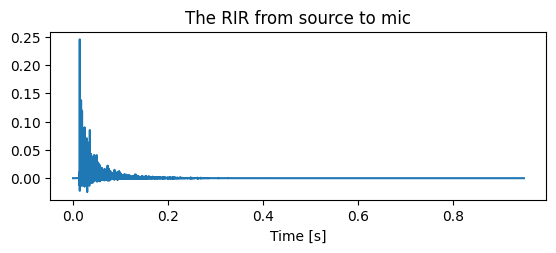

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pyroomacoustics as pra

# The desired reverberation time and dimensions of the room
rt60_tgt = 0.3  # seconds
room_dim = [10, 7.5, 3.5]  # meters

# import a mono wavfile as the source signal
# the sampling frequency should match that of the room
# fs, audio = wavfile.read("examples/samples/guitar_16k.wav")
fs = 16000
# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
)

# place the source in the room
room.add_source([2.5, 3.73, 1.76])

# define the locations of the microphones
mic_locs = [6.3, 4.87, 1.2]  # mic 1  # mic 2

# finally place the array in the room
room.add_microphone(mic_locs)

# Run the simulation (this will also build the RIR automatically)
room.compute_rir()

# Create a plot
plt.figure()

# plot one of the RIR. both can also be plotted using room.plot_rir()
rir = room.rir[0][0]
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(rir)) / room.fs, rir)
plt.title("The RIR from source to mic")
plt.xlabel("Time [s]")

In [59]:
train_sim_manifest = pd.read_csv(
    "/home/lucianius/workspace/BERP/data/noiseReverbSpeech/train_sim_manifest.csv"
)
val_sim_manifest = pd.read_csv(
    "/home/lucianius/workspace/BERP/data/noiseReverbSpeech/val_sim_manifest.csv"
)
sim_manifest = pd.concat([train_sim_manifest, val_sim_manifest])

In [60]:
sim_manifest

,reverbSpeech,volume_log10_unitary,Th,Tt,volume,volume_log10,distRcv,distRcv_norm,azimuth,elevation,snr_dB
0,reverbSpeech_No16026.wav,0.787,0.035,1.472,2706.0,3.432,8.277,0.287,0.176000,-0.000000,0
1,reverbSpeech_No34068.wav,0.634,0.025,2.216,1140.0,3.057,3.000,0.100,0.148000,0.047000,100
2,reverbSpeech_No15288.wav,1.000,0.019,8.648,9000.0,3.954,2.864,0.095,0.250000,0.000000,20
3,reverbSpeech_No8337.wav,1.000,0.019,8.648,9000.0,3.954,2.864,0.095,0.250000,0.000000,10
4,reverbSpeech_No40801.wav,0.979,0.016,3.324,8000.0,3.903,2.864,0.095,0.123000,0.059000,15
...,...,...,...,...,...,...,...,...,...,...,...
1995,reverbSpeech_No43518.wav,0.877,0.192,26.355,4500.0,3.653,28.350,1.000,0.154738,0.004269,10
1996,reverbSpeech_No43743.wav,0.780,0.100,2.726,2600.0,3.415,11.500,0.402,0.171485,0.048061,10
1997,reverbSpeech_No44737.wav,0.627,0.019,1.859,1100.0,3.041,3.415,0.114,-0.107452,-0.124295,0
1998,reverbSpeech_No45036.wav,0.120,0.027,0.501,63.0,1.799,1.637,0.051,-0.000000,0.000000,0


In [61]:
# unitary normalize the Th
Th = sim_manifest["Th"].values
print(f"upper bound: {Th.max()}, lower bound: {Th.min()}")
Th_norm = unitary_norm(torch.tensor(Th))

# azimuth and elevation
azimuth = sim_manifest["azimuth"].values
elevation = sim_manifest["elevation"].values
print(f"upper bound: {azimuth.max()}, lower bound: {azimuth.min().round(3)}")
print(f"upper bound: {elevation.max()}, lower bound: {elevation.min()}")
azimuth_norm = unitary_norm(torch.tensor(azimuth))
elevation_norm = unitary_norm(torch.tensor(elevation))

upper bound: 0.192, lower bound: 0.004
upper bound: 1.5, lower bound: -0.499
upper bound: 0.49, lower bound: -0.474


In [62]:
# insert the normalized values back to the dataframe
sim_manifest["Th_norm"] = Th_norm.numpy().round(3).tolist()
sim_manifest["azimuth_norm"] = azimuth_norm.numpy().round(3).tolist()
sim_manifest["elevation_norm"] = elevation_norm.numpy().round(3).tolist()

Text(0, 0.5, 'Number of RIRs')

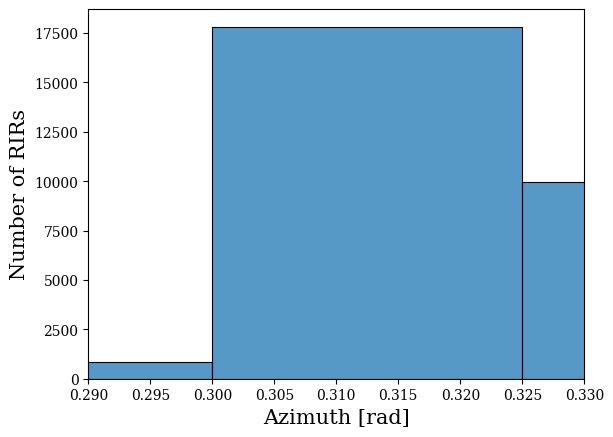

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

azimuth = sim_manifest["azimuth"].values

fig, ax = plt.subplots()
plt.rcParams["font.family"] = "serif"
hist = sns.histplot(
    x=azimuth_norm,
    multiple="stack",
    bins=40,
)
ax.set_xlim(0.29, 0.33)
ax.set_xlabel("Azimuth [rad]", fontname="serif", fontsize=15)
ax.set_ylabel("Number of RIRs", fontname="serif", fontsize=15)

<Axes: xlabel='Azimuth [rad]', ylabel='Number of RIRs'>

In [56]:
azimuth_labels = (azimuth_norm <= 0.325) & (azimuth_norm >= 0.300)
azimuth_labels.unique(return_counts=True)

(tensor([False,  True]), tensor([27616, 17814]))

Text(0, 0.5, 'Number of RIRs (log scale)')

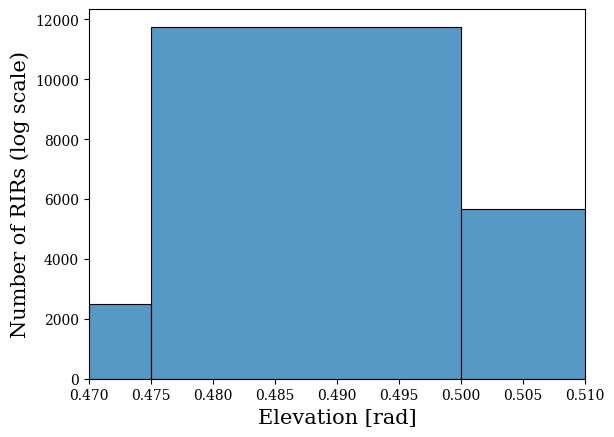

In [54]:
elevation = sim_manifest["elevation"].values

fig, ax = plt.subplots()
plt.rcParams["font.family"] = "serif"
sns.histplot(
    x=elevation_norm,
    multiple="stack",
    bins=40,
)
ax.set_xlim(0.47, 0.51)
ax.set_xlabel("Elevation [rad]", fontname="serif", fontsize=15)
ax.set_ylabel("Number of RIRs (log scale)", fontname="serif", fontsize=15)

In [58]:
elevation_labels = (elevation_norm <= 0.50) & (elevation_norm >= 0.475)
elevation_labels.unique(return_counts=True)

(tensor([False,  True]), tensor([33667, 11763]))

In [64]:
# insert the azimuth and elevation labels back to the dataframe
sim_manifest["azimuth_classifier"] = azimuth_labels.tolist()
sim_manifest["elevation_classifier"] = elevation_labels.tolist()

# split the dataframe into train and validation sets
train_sim_manifest = sim_manifest[: len(train_sim_manifest)]
val_sim_manifest = sim_manifest[len(train_sim_manifest) :]

In [65]:
train_sim_manifest

,reverbSpeech,volume_log10_unitary,Th,Tt,volume,volume_log10,distRcv,distRcv_norm,azimuth,elevation,snr_dB,Th_norm,azimuth_norm,elevation_norm,azimuth_classifier,elevation_classifier
0,reverbSpeech_No16026.wav,0.787,0.035,1.472,2706.0,3.432,8.277,0.287,0.176,-0.000,0,0.165,0.338,0.492,False,True
1,reverbSpeech_No34068.wav,0.634,0.025,2.216,1140.0,3.057,3.000,0.100,0.148,0.047,100,0.112,0.324,0.540,True,False
2,reverbSpeech_No15288.wav,1.000,0.019,8.648,9000.0,3.954,2.864,0.095,0.250,0.000,20,0.080,0.375,0.492,False,True
3,reverbSpeech_No8337.wav,1.000,0.019,8.648,9000.0,3.954,2.864,0.095,0.250,0.000,10,0.080,0.375,0.492,False,True
4,reverbSpeech_No40801.wav,0.979,0.016,3.324,8000.0,3.903,2.864,0.095,0.123,0.059,15,0.064,0.311,0.553,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43425,reverbSpeech_No11.wav,1.000,0.019,8.648,9000.0,3.954,2.864,0.095,0.250,0.000,100,0.080,0.375,0.492,False,True
43426,reverbSpeech_No13544.wav,1.000,0.019,8.648,9000.0,3.954,2.864,0.095,0.250,0.000,10,0.080,0.375,0.492,False,True
43427,reverbSpeech_No10370.wav,0.320,0.014,0.645,194.0,2.288,1.502,0.047,-0.138,0.412,15,0.053,0.181,0.919,False,False
43428,reverbSpeech_No35997.wav,1.000,0.019,8.648,9000.0,3.954,2.864,0.095,0.250,0.000,10,0.080,0.375,0.492,False,True


In [66]:
val_sim_manifest

,reverbSpeech,volume_log10_unitary,Th,Tt,volume,volume_log10,distRcv,distRcv_norm,azimuth,elevation,snr_dB,Th_norm,azimuth_norm,elevation_norm,azimuth_classifier,elevation_classifier
0,reverbSpeech_No45032.wav,0.979,0.016,3.324,8000.0,3.903,2.864,0.095,0.122591,0.059158,0,0.064,0.311,0.553,True,False
1,reverbSpeech_No44103.wav,0.979,0.016,3.779,8000.0,3.903,2.864,0.095,0.122591,0.059158,100,0.064,0.311,0.553,True,False
2,reverbSpeech_No45403.wav,0.979,0.016,3.779,8000.0,3.903,2.864,0.095,0.122591,0.059158,15,0.064,0.311,0.553,True,False
3,reverbSpeech_No43963.wav,0.833,0.096,9.175,3500.0,3.544,14.880,0.522,0.122525,0.048951,5,0.489,0.311,0.542,True,False
4,reverbSpeech_No44534.wav,0.979,0.016,3.324,8000.0,3.903,2.864,0.095,0.122591,0.059158,20,0.064,0.311,0.553,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,reverbSpeech_No43518.wav,0.877,0.192,26.355,4500.0,3.653,28.350,1.000,0.154738,0.004269,10,1.000,0.327,0.496,False,True
1996,reverbSpeech_No43743.wav,0.780,0.100,2.726,2600.0,3.415,11.500,0.402,0.171485,0.048061,10,0.511,0.335,0.542,False,False
1997,reverbSpeech_No44737.wav,0.627,0.019,1.859,1100.0,3.041,3.415,0.114,-0.107452,-0.124295,0,0.080,0.196,0.363,False,False
1998,reverbSpeech_No45036.wav,0.120,0.027,0.501,63.0,1.799,1.637,0.051,-0.000000,0.000000,0,0.122,0.250,0.492,False,True


In [67]:
train_sim_manifest.to_csv(
    "/home/lucianius/workspace/BERP/data/noiseReverbSpeech/train_sim_manifest.csv",
    index=False,
)
val_sim_manifest.to_csv(
    "/home/lucianius/workspace/BERP/data/noiseReverbSpeech/val_sim_manifest.csv",
    index=False,
)